In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm


In [90]:
# load the dataset
transactions = pd.read_csv('transactions.csv')
holidays_events = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')

In [91]:
# Convert date columns to datetime
train['date'] = pd.to_datetime(train['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])

# Filter data for top stores
top_stores = [44, 45, 47]
train_top_stores = train[train['store_nbr'].isin(top_stores)]

# Aggregate sales by store, date, and family
#aggregated_sales = train_top_stores.groupby(['store_nbr', 'date', 'family']).agg({'sales': 'sum'}).reset_index()

# Merge datasets
sales_holidays = pd.merge(train_top_stores, holidays_events, on='date', how='left')
sales_holidays_oil = pd.merge(sales_holidays, oil, on='date', how='left')
sales_holidays_oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Apply interpolation safely using transform
sales_holidays_oil['sales'] = sales_holidays_oil.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.interpolate(method='linear'))


# Split the data into training and forecasting sets
train_end_date = '2017-08-01'
forecast_start_date = '2017-08-02'
forecast_end_date = '2017-08-15'

train_data = sales_holidays_oil[sales_holidays_oil['date'] <= train_end_date]
forecast_data = sales_holidays_oil[(sales_holidays_oil['date'] >= forecast_start_date) & (sales_holidays_oil['date'] <= forecast_end_date)]


In [92]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
0,1254,2013-01-01,44,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14
1,1255,2013-01-01,44,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14
2,1256,2013-01-01,44,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14
3,1257,2013-01-01,44,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14
4,1258,2013-01-01,44,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14


In [93]:
forecast_data.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
168300,2977194,2017-08-02,44,AUTOMOTIVE,15.0,0,NaN,NaN,NaN,NaN,NaN,49.6
168301,2977195,2017-08-02,44,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,49.6
168302,2977196,2017-08-02,44,BEAUTY,17.0,1,NaN,NaN,NaN,NaN,NaN,49.6
168303,2977197,2017-08-02,44,BEVERAGES,9461.0,31,NaN,NaN,NaN,NaN,NaN,49.6
168304,2977198,2017-08-02,44,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,49.6


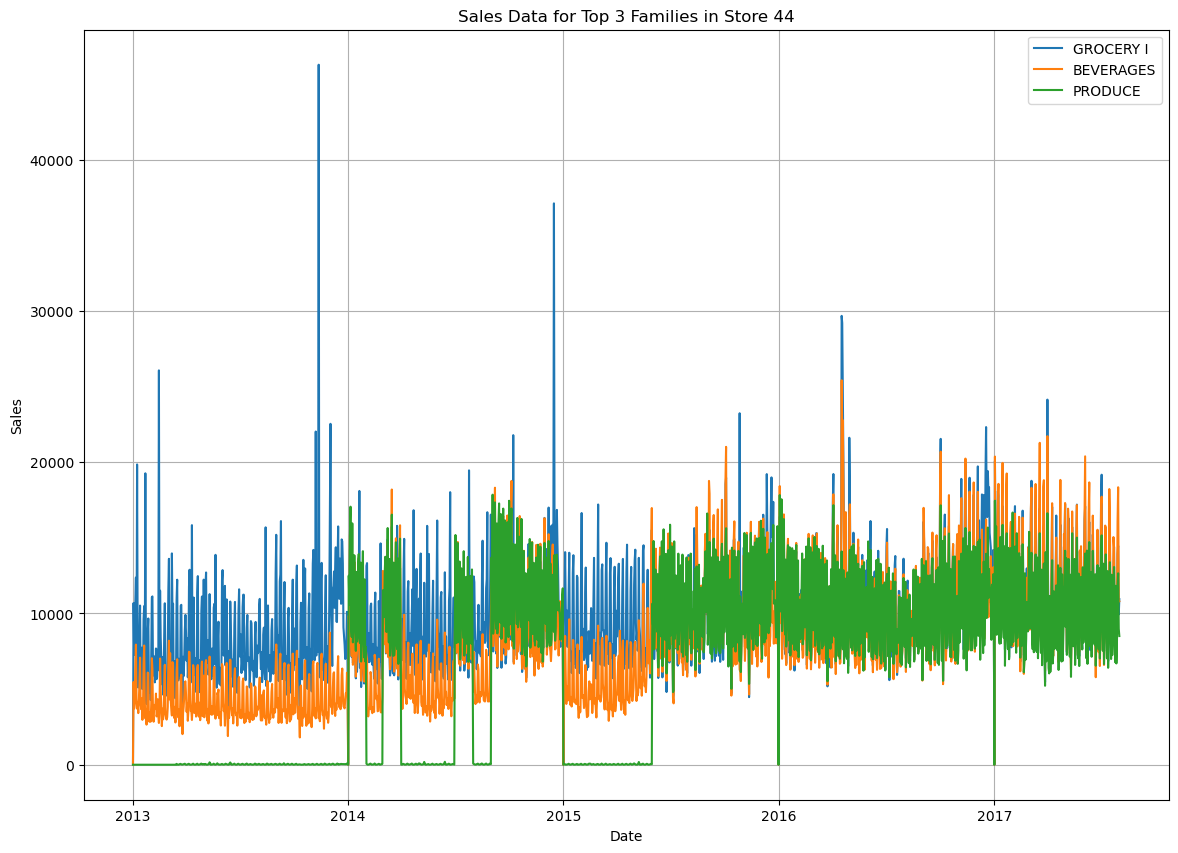

In [94]:
# Identify top 3 families by total sales
top_families = train_data.groupby('family')['sales'].sum().nlargest(3).index
# Filter data for store 44
store = 44
train_store44 = train_data[train_data['store_nbr'] == store]
forecast_store44 = forecast_data[forecast_data['store_nbr'] == store]
# Plot sales data for top 5 families in store 44
plt.figure(figsize=(14, 10))
for family in top_families:
    family_data = train_store44[train_store44['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family)

plt.title('Sales Data for Top 3 Families in Store 44')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# Select the top 1 family
top_family = top_families[0]

# Filter data for the top 1 family
train_family_data = train_store44[train_store44['family'] == top_family]
forecast_family_data = forecast_store44[forecast_store44['family'] == top_family]

In [96]:
train_family_data.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
12,1266,2013-01-01,44,GROCERY I,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14
111,3048,2013-01-02,44,GROCERY I,10686.0,0,NaN,NaN,NaN,NaN,NaN,93.14
210,4830,2013-01-03,44,GROCERY I,7342.0,0,NaN,NaN,NaN,NaN,NaN,92.97
309,6612,2013-01-04,44,GROCERY I,7250.0,0,NaN,NaN,NaN,NaN,NaN,93.12
408,8394,2013-01-05,44,GROCERY I,10699.0,0,Work Day,National,Ecuador,Recupero puente Navidad,False,93.20


In [97]:
forecast_family_data.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
168312,2977206,2017-08-02,44,GROCERY I,11156.0,68,NaN,NaN,NaN,NaN,NaN,49.60
168411,2978988,2017-08-03,44,GROCERY I,8419.0,35,NaN,NaN,NaN,NaN,NaN,49.03
168510,2980770,2017-08-04,44,GROCERY I,9346.0,41,NaN,NaN,NaN,NaN,NaN,49.57
168609,2982552,2017-08-05,44,GROCERY I,12463.0,42,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False,49.37
168708,2984334,2017-08-06,44,GROCERY I,13248.0,41,NaN,NaN,NaN,NaN,NaN,49.37


In [43]:
# Determine the best ARIMA order for the top family
def find_best_arima_order(data):
    model = pm.auto_arima(data['sales'],
                          seasonal=True,
                          m=12,  # Assuming monthly seasonality
                          stepwise=True,
                          suppress_warnings=True)
    return model.order, model.seasonal_order

order, seasonal_order = find_best_arima_order(train_family_data)
print(f"Store {store}, Family {top_family} - Best ARIMA order: {order}, Seasonal order: {seasonal_order}")

# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")

Store 44, Family GROCERY I - Best ARIMA order: (2, 1, 2), Seasonal order: (2, 0, 2, 12)


C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xuan916\AppData\Local\anaconda3\

RMSE for Store 44, Family GROCERY I: 2121.678736794928


C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


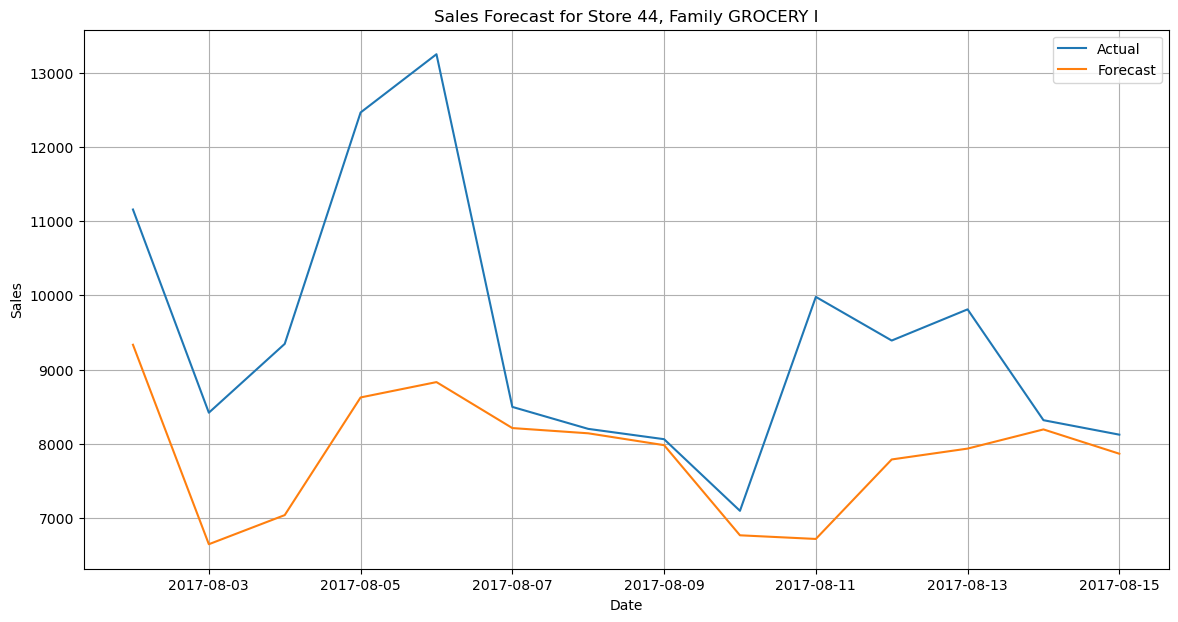

In [45]:
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xuan916\AppData\Local\anaconda3\

RMSE for Store 44, Family GROCERY I: 1065.2401792093865


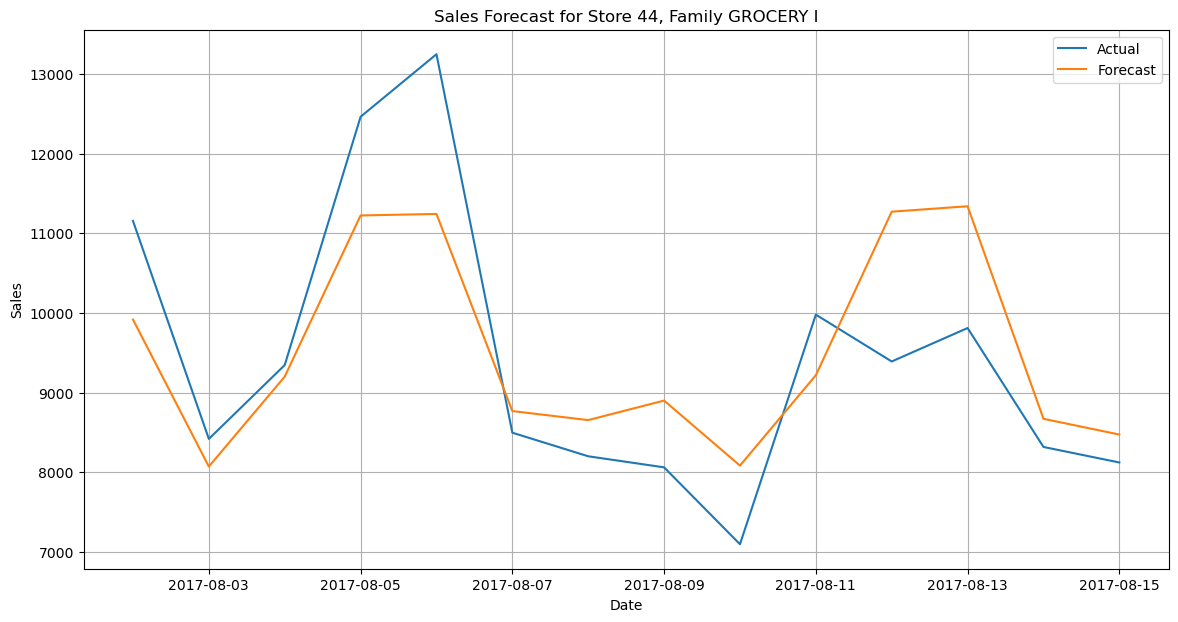

In [98]:
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(2, 1, 2), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

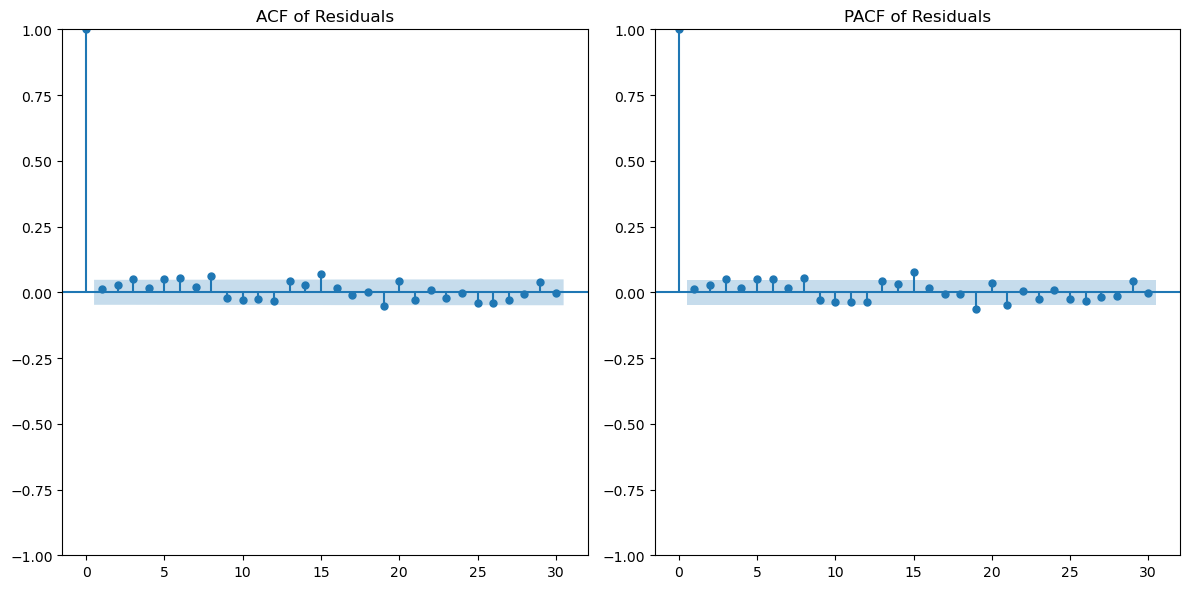

In [99]:
# Extract residuals
residuals = model_fit.resid

# Plot ACF and PACF of residuals
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title('ACF of Residuals')
plt.subplot(122)
plot_pacf(residuals, lags=30, ax=plt.gca())
plt.title('PACF of Residuals')
plt.tight_layout()
plt.show()

In [101]:
# Perform Ljung-Box test for autocorrelation
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[1], return_df=True)
print('Ljung-Box test:\n', lb_test)

Ljung-Box test:
     lb_stat  lb_pvalue
1  0.202284   0.652883


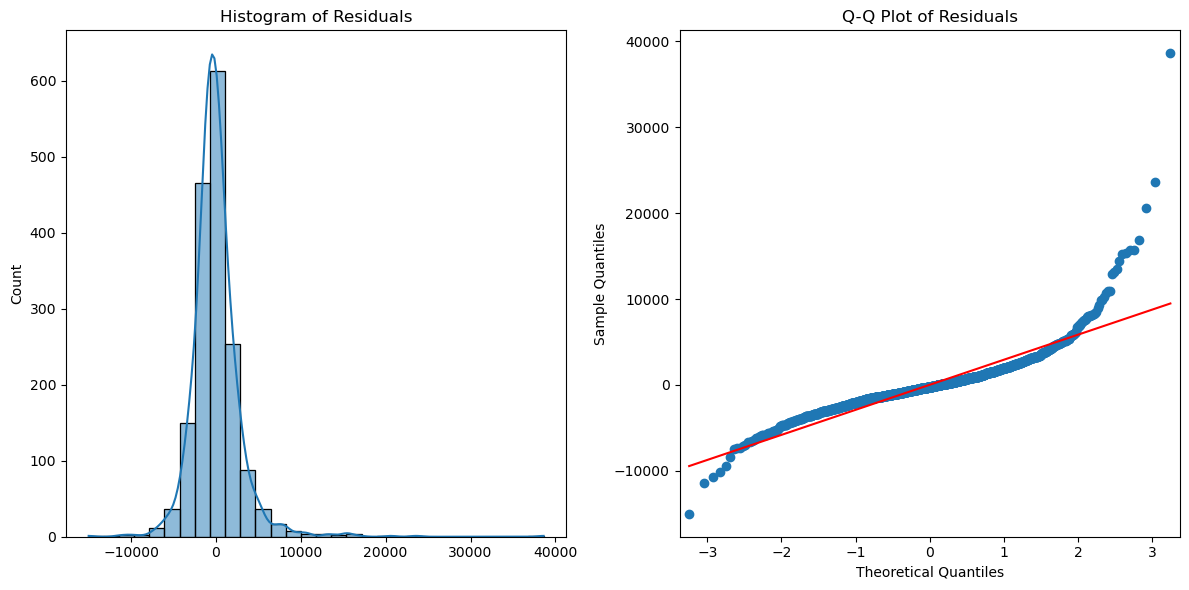

In [102]:
# Plot histogram and Q-Q plot of residuals
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.subplot(122)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\stats

RMSE for Store 44, Family GROCERY I: 1077.246771428365


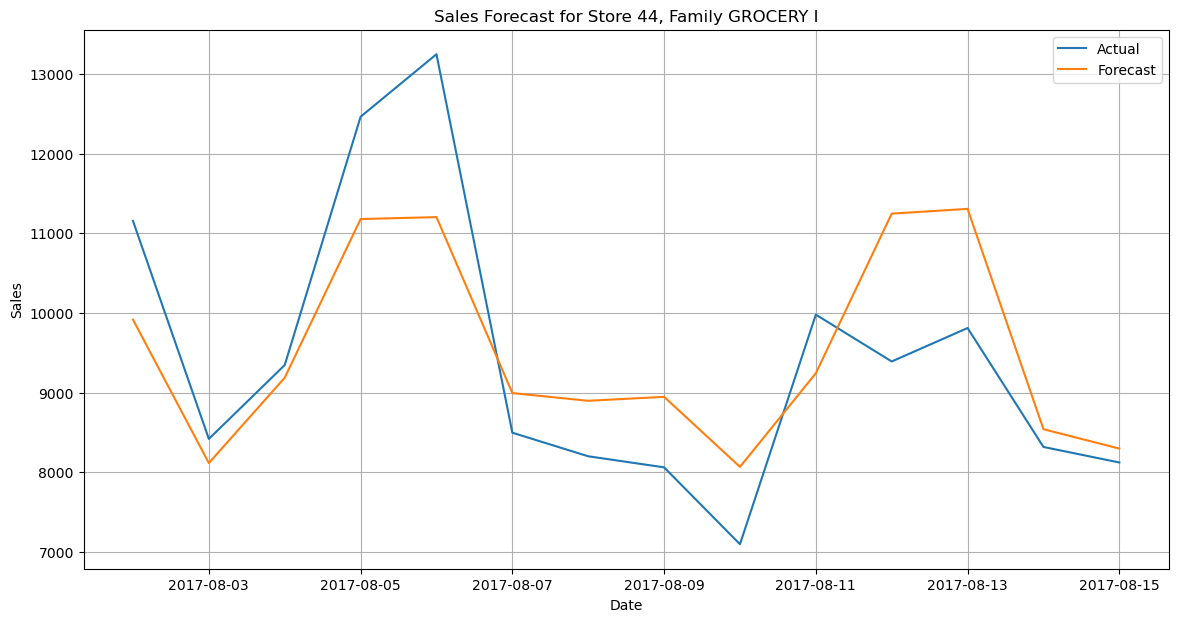

In [66]:
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(2, 1, 3), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xuan916\AppData\Local\anaconda3\

RMSE for Store 45, Family GROCERY I: 1223.4528216025508


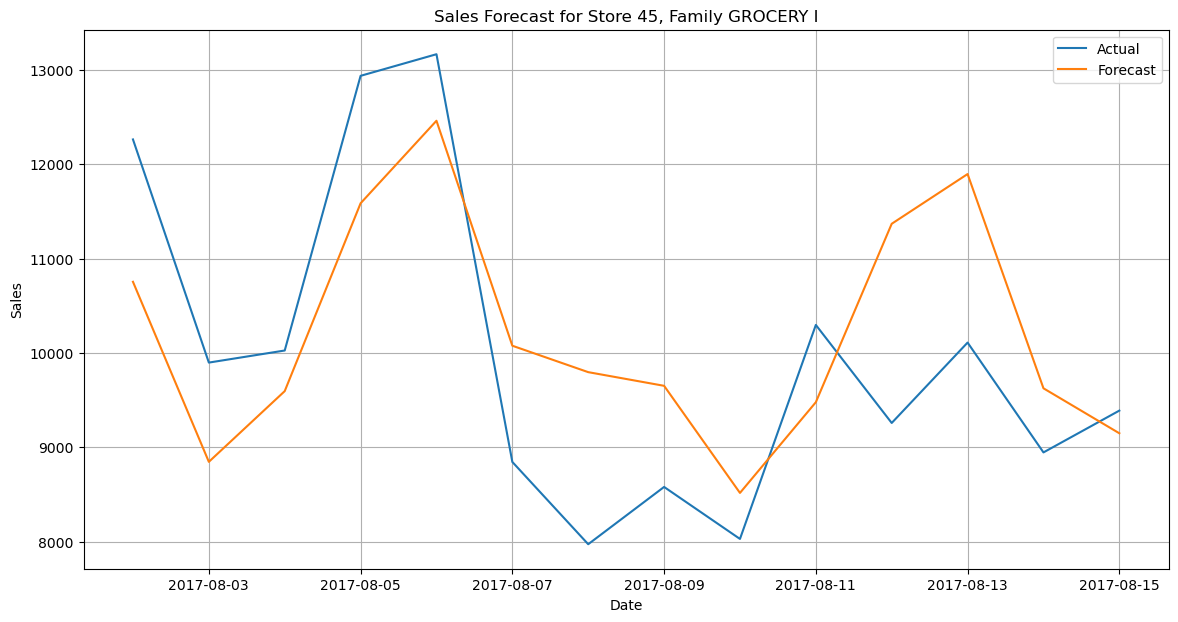

In [88]:
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(3, 1, 2), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

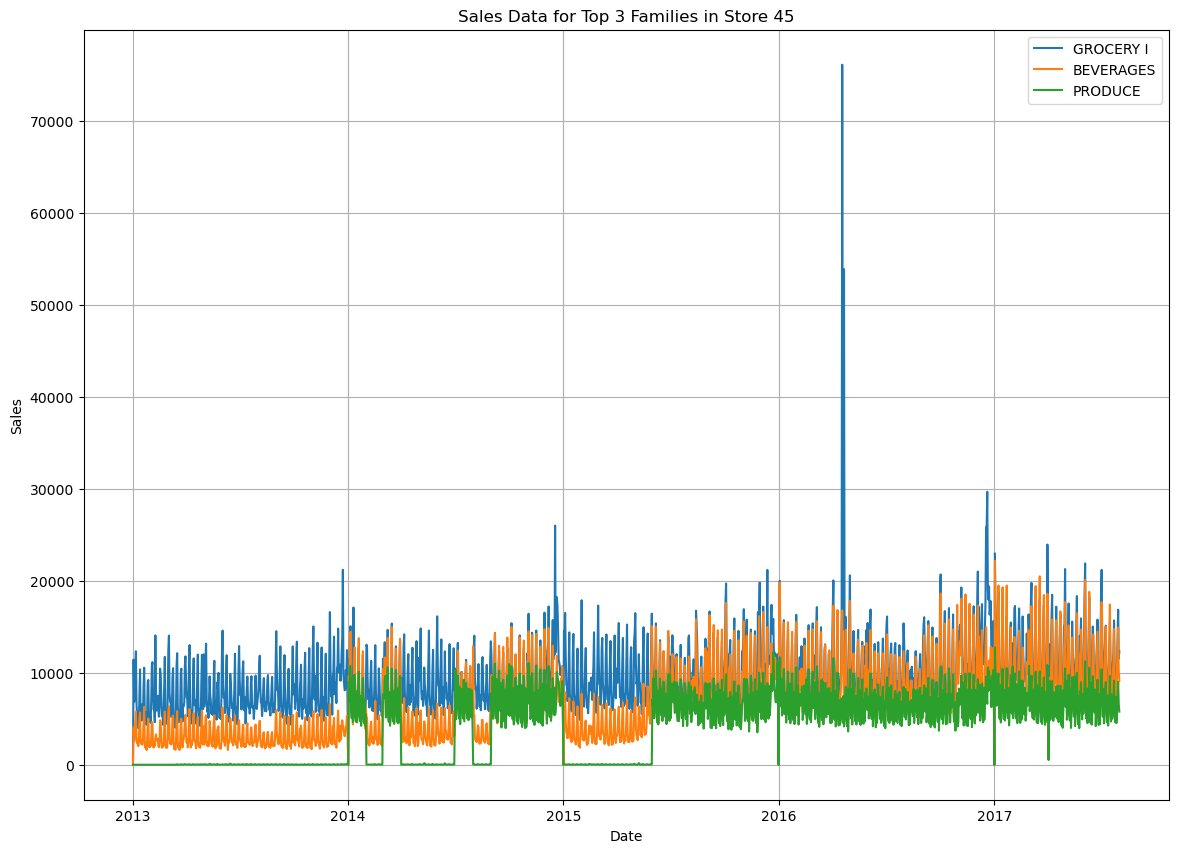

In [104]:
# Filter data for store 45
store = 45
train_store45 = train_data[train_data['store_nbr'] == store]
forecast_store45 = forecast_data[forecast_data['store_nbr'] == store]
# Plot sales data for top 5 families in store 45
plt.figure(figsize=(14, 10))
for family in top_families:
    family_data = train_store45[train_store45['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family)

plt.title('Sales Data for Top 3 Families in Store 45')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Select the top 1 family
top_family = top_families[0]

# Filter data for the top 1 family
train_family_data = train_store45[train_store45['family'] == top_family]
forecast_family_data = forecast_store45[forecast_store45['family'] == top_family]

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xuan916\AppData\Local\anaconda3\

RMSE for Store 45, Family GROCERY I: 1163.8304270287142


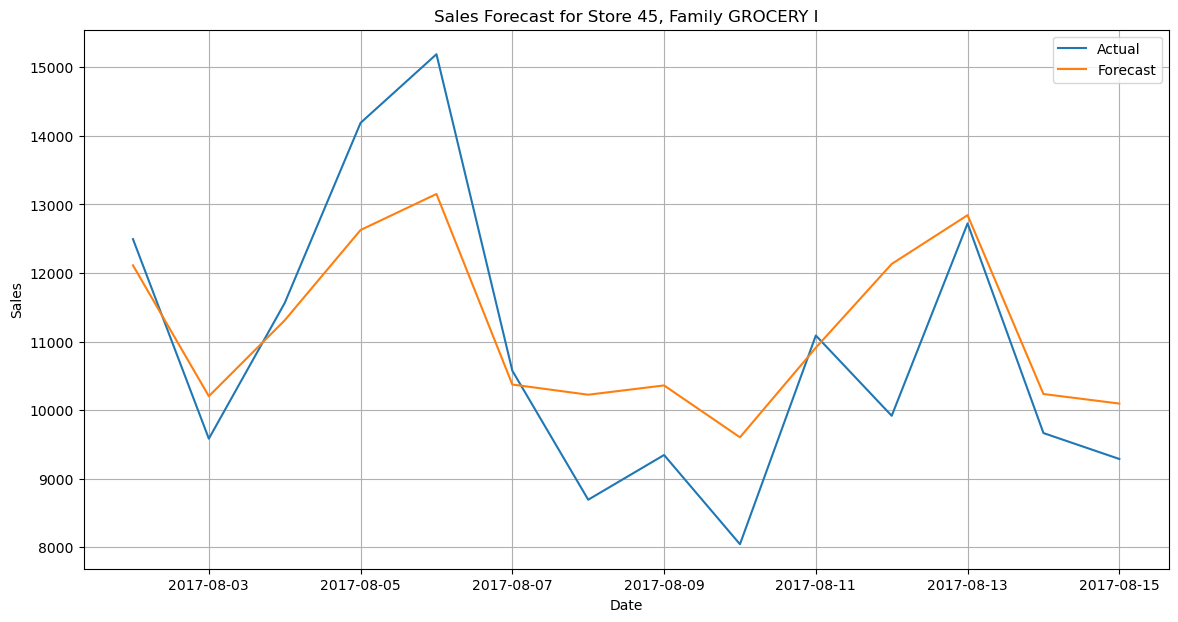

In [80]:
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(3, 1, 2), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

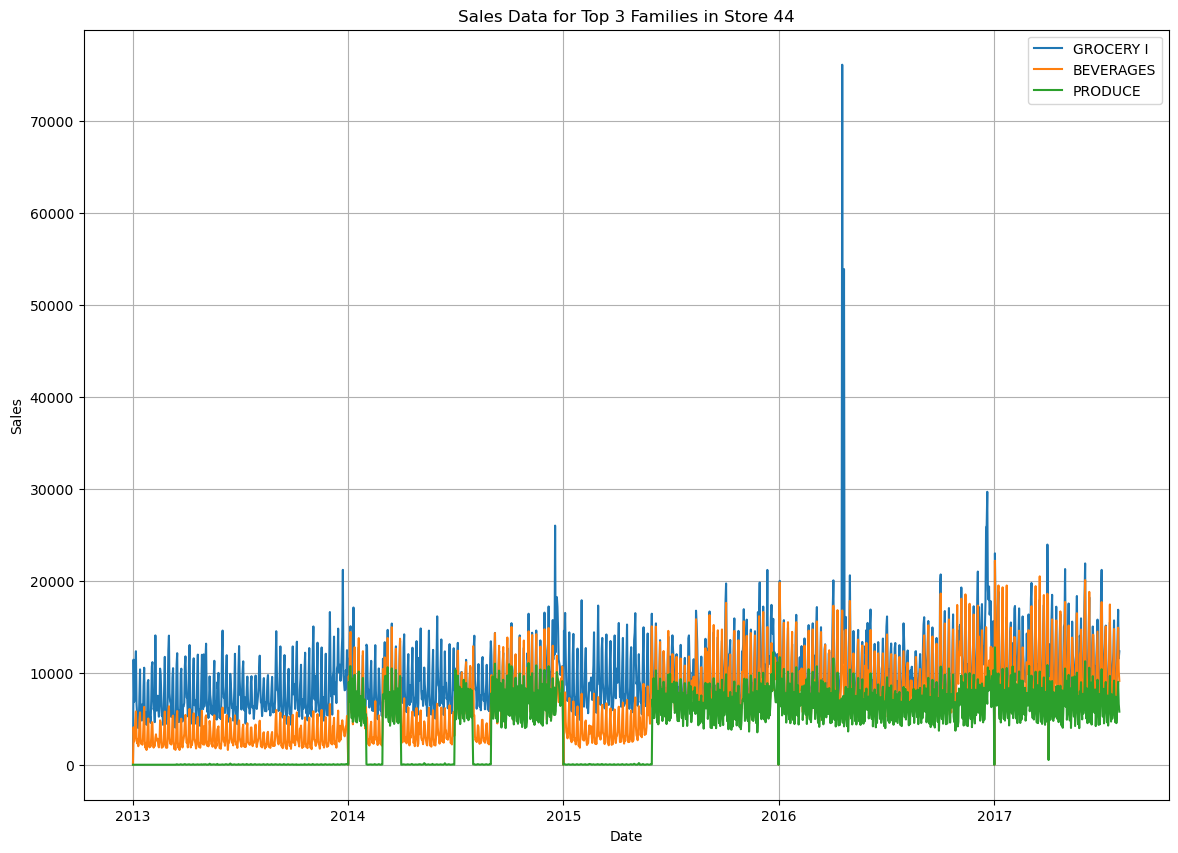

In [77]:
# Filter data for store 47
store = 47
train_store47 = train_data[train_data['store_nbr'] == store]
forecast_store47 = forecast_data[forecast_data['store_nbr'] == store]
# Plot sales data for top 5 families in store 47
plt.figure(figsize=(14, 10))
for family in top_families:
    family_data = train_store47[train_store47['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family)

plt.title('Sales Data for Top 3 Families in Store 47')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xuan916\AppData\Local\anaconda3\

RMSE for Store 45, Family GROCERY I: 1223.4528216025508


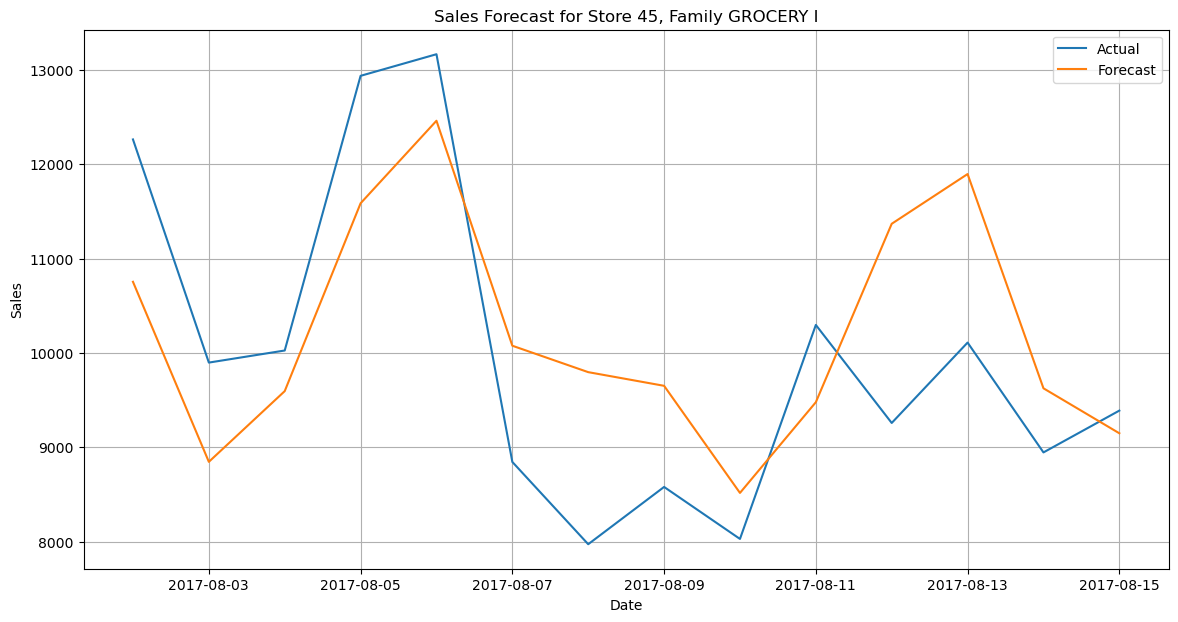

In [81]:
# Select the top 1 family
top_family = top_families[0]

# Filter data for the top 1 family
train_family_data = train_store47[train_store47['family'] == top_family]
forecast_family_data = forecast_store47[forecast_store47['family'] == top_family]
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(3, 1, 2), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\stats

RMSE for Store 45, Family GROCERY I: 1192.3075109257002


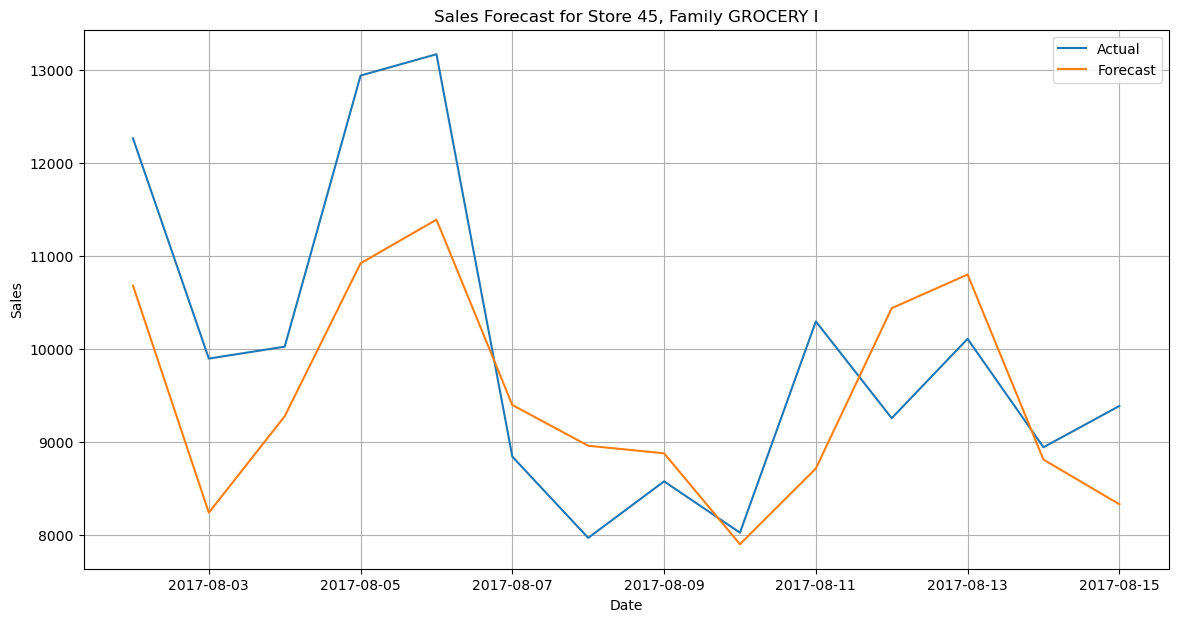

In [82]:
# Select the top 1 family
top_family = top_families[0]

# Filter data for the top 1 family
train_family_data = train_store47[train_store47['family'] == top_family]
forecast_family_data = forecast_store47[forecast_store47['family'] == top_family]
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(3, 1, 3), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\xuan916\AppData\Local\anaconda3\Lib\site-packages\stats

RMSE for Store 45, Family GROCERY I: 1204.1958098920732


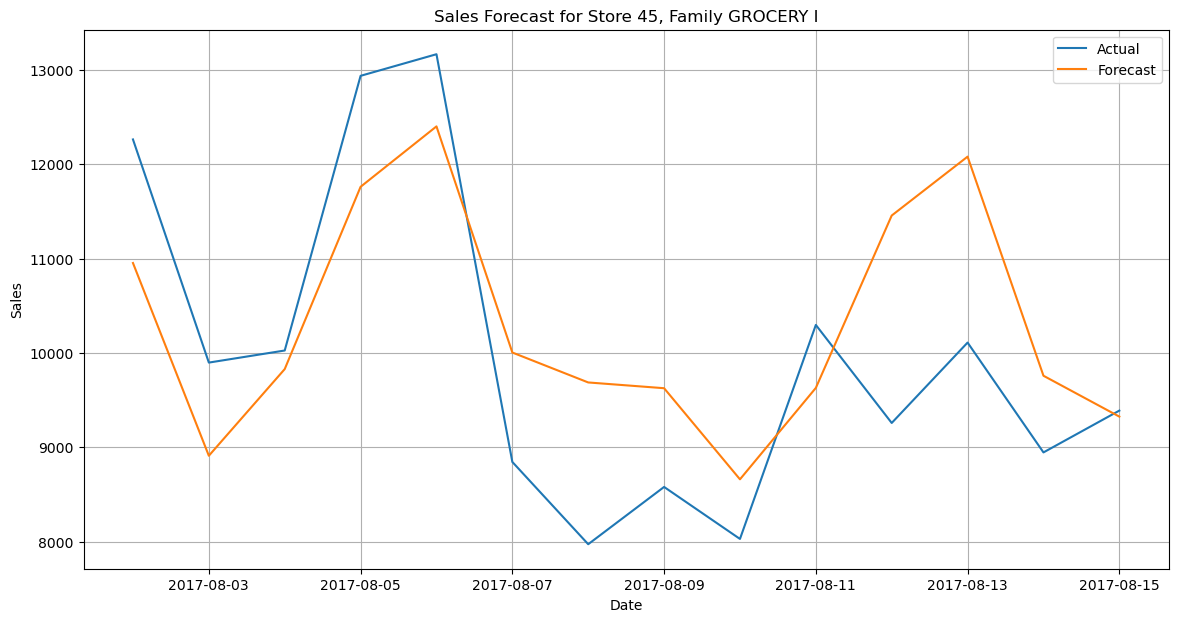

In [83]:
# Select the top 1 family
top_family = top_families[0]

# Filter data for the top 1 family
train_family_data = train_store47[train_store47['family'] == top_family]
forecast_family_data = forecast_store47[forecast_store47['family'] == top_family]
# Train ARIMAX model for the top family
exog_vars = ['onpromotion','dcoilwtico']
model = SARIMAX(train_family_data['sales'], exog=train_family_data[exog_vars], order=(2, 1, 3), seasonal_order=(2, 0, 2, 7))
model_fit = model.fit(disp=False)

# Forecast for the forecasting period
forecast = model_fit.predict(start=len(train_family_data), end=len(train_family_data)+len(forecast_family_data)-1, exog=forecast_family_data[exog_vars])

# Calculate RMSE for the top family
rmse = np.sqrt(mean_squared_error(forecast_family_data['sales'], forecast))
print(f"RMSE for Store {store}, Family {top_family}: {rmse}")
# Plot Actual vs Forecast for the top family
plt.figure(figsize=(14, 7))
plt.plot(forecast_family_data['date'], forecast_family_data['sales'], label='Actual')
plt.plot(forecast_family_data['date'], forecast, label='Forecast')
plt.title(f'Sales Forecast for Store {store}, Family {top_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()